# Data Exploration

In [1]:
import os

base = "/kaggle/input/eye-diseases-classification/dataset"

for folder in os.listdir(base):
    path = os.path.join(base, folder)
    if os.path.isdir(path):
        print(folder, ":", len(os.listdir(path)))


glaucoma : 1007
normal : 1074
diabetic_retinopathy : 1098
cataract : 1038


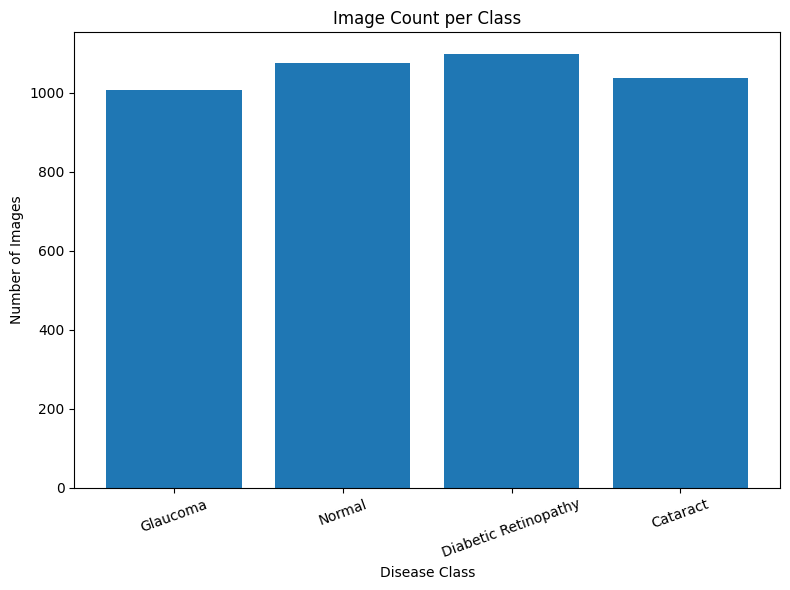

In [2]:
import matplotlib.pyplot as plt


classes = ["Glaucoma", "Normal", "Diabetic Retinopathy", "Cataract"]
counts = [1007, 1074, 1098, 1038]

plt.figure(figsize=(8, 6))
plt.bar(classes, counts)
plt.xlabel("Disease Class")
plt.ylabel("Number of Images")
plt.title("Image Count per Class")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [3]:
for folder in os.listdir(base):
    sample_path = os.path.join(base, folder)
    files = os.listdir(sample_path)
    print("\nClass:", folder)
    print("Sample files:", files[:5])



Class: glaucoma
Sample files: ['1255_right.jpg', '1482_left.jpg', '_398_8823411.jpg', '_309_4110303.jpg', '_13_697490.jpg']

Class: normal
Sample files: ['2396_left.jpg', '3017_left.jpg', '3142_right.jpg', '2710_right.jpg', '1034_right.jpg']

Class: diabetic_retinopathy
Sample files: ['10942_right.jpeg', '10672_left.jpeg', '11232_right.jpeg', '10130_right.jpeg', '11221_left.jpeg']

Class: cataract
Sample files: ['_394_1321417.jpg', '_253_643151.jpg', '_101_5139882.jpg', '_314_8133392.jpg', '_275_3439882.jpg']


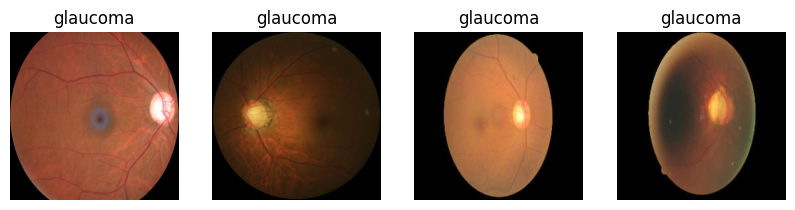

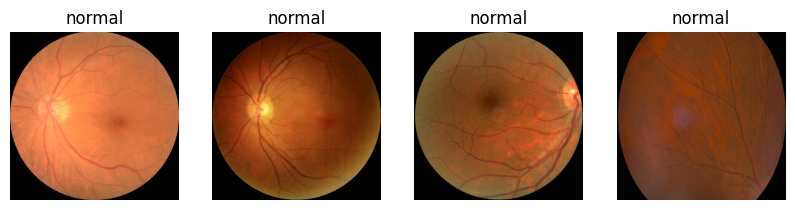

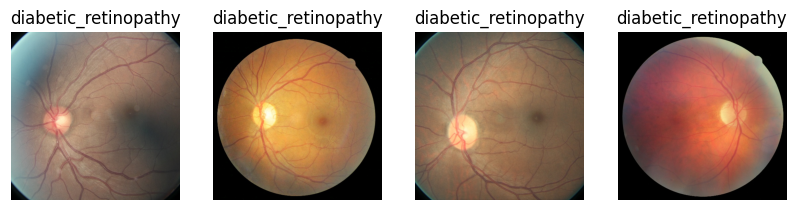

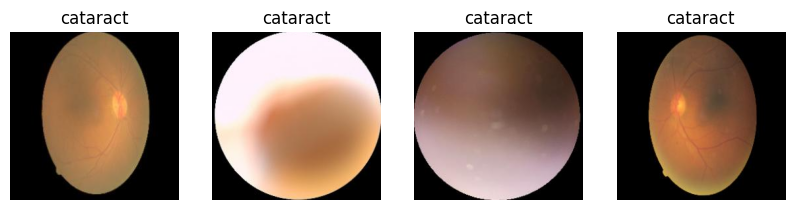

In [4]:
import cv2
import matplotlib.pyplot as plt

def show_sample_images(class_name, n=4):
    folder = os.path.join(base, class_name)
    files = os.listdir(folder)[:n]

    plt.figure(figsize=(10, 5))
    
    for i, f in enumerate(files):
        img = cv2.imread(os.path.join(folder, f))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(class_name)

    plt.show()

for cls in os.listdir(base):
    show_sample_images(cls)


In [5]:
import numpy as np

sizes = []

for cls in os.listdir(base):
    folder = os.path.join(base, cls)
    for fname in os.listdir(folder)[:200]: 
        img = cv2.imread(os.path.join(folder, fname))
        if img is not None:
            h, w, c = img.shape
            sizes.append((h, w))

sizes = np.array(sizes)
print("Average size:", sizes.mean(axis=0))
print("Min size:", sizes.min(axis=0))
print("Max size:", sizes.max(axis=0))


Average size: [503.4  554.72]
Min size: [256 256]
Max size: [1728 2592]


# Data Split

In [6]:
import os
import shutil
import random

source_base = "/kaggle/input/eye-diseases-classification/dataset"
dest_base = "/kaggle/working/split_dataset"


train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15


for split in ["train", "val", "test"]:
    for cls in os.listdir(source_base):
        os.makedirs(os.path.join(dest_base, split, cls), exist_ok=True)


for cls in os.listdir(source_base):
    cls_path = os.path.join(source_base, cls)
    images = [f for f in os.listdir(cls_path) if f.endswith(('.jpg','.jpeg','.png'))]
    
    random.shuffle(images)
    
    n = len(images)
    train_end = int(train_ratio * n)
    val_end = int((train_ratio + val_ratio) * n)

    for i, img in enumerate(images):
        src = os.path.join(cls_path, img)
        
        if i < train_end:
            dst = os.path.join(dest_base, "train", cls, img)
        elif i < val_end:
            dst = os.path.join(dest_base, "val", cls, img)
        else:
            dst = os.path.join(dest_base, "test", cls, img)

        shutil.copy(src, dst)

print("Dataset successfully split into train/val/test!")


Dataset successfully split into train/val/test!


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (224, 224)
BATCH = 16

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True
).flow_from_directory(
    dest_base + "/train",
    target_size=IMAGE_SIZE,
    batch_size=BATCH,
    class_mode="categorical"
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    dest_base + "/val",
    target_size=IMAGE_SIZE,
    batch_size=BATCH,
    class_mode="categorical"
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    dest_base + "/test",
    target_size=IMAGE_SIZE,
    batch_size=BATCH,
    class_mode="categorical",
    shuffle=False
)


2025-12-09 12:30:43.334559: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765283443.515471      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765283443.569921      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Found 2949 images belonging to 4 classes.
Found 633 images belonging to 4 classes.
Found 635 images belonging to 4 classes.


# Base MobileNetV2

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

num_classes = train_gen.num_classes

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  

x = GlobalAveragePooling2D()(base_model.output)
output = Dense(num_classes, activation="softmax")(x)

mobilenet_model = Model(inputs=base_model.input, outputs=output)

mobilenet_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

mobilenet_history = mobilenet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20
)


I0000 00:00:1765283460.158822      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1765283467.979574      86 service.cc:148] XLA service 0x7a9a28002500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765283467.980422      86 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1765283468.855866      86 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/185 ━━━━━━━━━━━━━━━━━━━━ 27:58 9s/step - accuracy: 0.3125 - loss: 1.3915

I0000 00:00:1765283472.247395      86 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


185/185 ━━━━━━━━━━━━━━━━━━━━ 65s 301ms/step - accuracy: 0.6204 - loss: 0.8975 - val_accuracy: 0.7362 - val_loss: 0.6418
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 48s 257ms/step - accuracy: 0.8009 - loss: 0.5267 - val_accuracy: 0.7457 - val_loss: 0.6416
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 47s 254ms/step - accuracy: 0.8302 - loss: 0.4843 - val_accuracy: 0.7378 - val_loss: 0.6790
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 47s 252ms/step - accuracy: 0.8311 - loss: 0.4494 - val_accuracy: 0.7630 - val_loss: 0.6268
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 47s 252ms/step - accuracy: 0.8415 - loss: 0.4222 - val_accuracy: 0.7457 - val_loss: 0.6624
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 47s 252ms/step - accuracy: 0.8565 - loss: 0.3938 - val_accuracy: 0.7520 - val_loss: 0.6945
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 47s 256ms/step - accuracy: 0.8620 - loss: 0.3773 - val_accuracy: 0.7362 - val_loss: 0.7143
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 47s 255ms/step - accuracy: 0.8578 - loss: 0.3791 - val

# Evaluation on Test Set

In [9]:

test_loss, test_accuracy = mobilenet_model.evaluate(test_gen)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.8297 - loss: 0.5441
Test Loss: 0.5820
Test Accuracy: 80.63%


# Confusion Matrix and Classification Report (base_line model)

In [10]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report


y_pred = mobilenet_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes


cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)


target_names = list(test_gen.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=target_names))


40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 190ms/step
Confusion Matrix:
 [[135   3   6  12]
 [  0 152   0  13]
 [  3  15  88  46]
 [  4  20   1 137]]
                      precision    recall  f1-score   support

            cataract       0.95      0.87      0.91       156
diabetic_retinopathy       0.80      0.92      0.86       165
            glaucoma       0.93      0.58      0.71       152
              normal       0.66      0.85      0.74       162

            accuracy                           0.81       635
           macro avg       0.83      0.80      0.80       635
        weighted avg       0.83      0.81      0.80       635



# Improved MobileNet V2

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np


num_classes = train_gen.num_classes

base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = False   



x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)        
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

improved_model = Model(inputs=base_model.input, outputs=output)


improved_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_top = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True, verbose=1),
    ModelCheckpoint("improved_model_top.h5", monitor="val_loss", save_best_only=True)
]

print("=== Stage 1: Training top layers ===")
history_top = improved_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=callbacks_top
)



base_model.trainable = True


for layer in base_model.layers[:-80]:
    layer.trainable = False


improved_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks_finetune = [
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1),
    EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
    ModelCheckpoint("improved_model_finetuned.h5", monitor="val_loss", save_best_only=True)
]

print("=== Stage 2: Fine-tuning last layers ===")
history_finetune = improved_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks_finetune
)



test_loss, test_acc = improved_model.evaluate(test_gen)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%\n")


y_pred = improved_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

target_names = list(test_gen.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=target_names)
print("\nClassification Report:\n", report)


=== Stage 1: Training top layers ===
Epoch 1/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.5777 - loss: 1.1087

185/185 ━━━━━━━━━━━━━━━━━━━━ 65s 305ms/step - accuracy: 0.5781 - loss: 1.1074 - val_accuracy: 0.6998 - val_loss: 0.7322 - learning_rate: 0.0010
Epoch 2/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 47s 254ms/step - accuracy: 0.7743 - loss: 0.6195 - val_accuracy: 0.6888 - val_loss: 0.7459 - learning_rate: 0.0010
Epoch 3/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.7995 - loss: 0.5295

185/185 ━━━━━━━━━━━━━━━━━━━━ 46s 251ms/step - accuracy: 0.7994 - loss: 0.5297 - val_accuracy: 0.7283 - val_loss: 0.6913 - learning_rate: 0.0010
Epoch 4/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.7714 - loss: 0.5952

185/185 ━━━━━━━━━━━━━━━━━━━━ 46s 247ms/step - accuracy: 0.7715 - loss: 0.5950 - val_accuracy: 0.7725 - val_loss: 0.6234 - learning_rate: 0.0010
Epoch 5/5
185/185 ━━━━━━━━━━━━━━━━━━━━ 46s 246ms/step - accuracy: 0.7910 - loss: 0.5674 - val_accuracy: 0.7551 - val_loss: 0.6652 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 4.
=== Stage 2: Fine-tuning last layers ===
Epoch 1/20


E0000 00:00:1765284734.465454      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765284734.661620      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - accuracy: 0.6797 - loss: 0.9283

185/185 ━━━━━━━━━━━━━━━━━━━━ 85s 323ms/step - accuracy: 0.6800 - loss: 0.9274 - val_accuracy: 0.6240 - val_loss: 1.3371 - learning_rate: 1.0000e-04
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8306 - loss: 0.5014

185/185 ━━━━━━━━━━━━━━━━━━━━ 45s 245ms/step - accuracy: 0.8307 - loss: 0.5013 - val_accuracy: 0.6603 - val_loss: 1.2814 - learning_rate: 1.0000e-04
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8721 - loss: 0.3791

185/185 ━━━━━━━━━━━━━━━━━━━━ 45s 244ms/step - accuracy: 0.8721 - loss: 0.3791 - val_accuracy: 0.6603 - val_loss: 0.9499 - learning_rate: 1.0000e-04
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 45s 242ms/step - accuracy: 0.8729 - loss: 0.3769 - val_accuracy: 0.7125 - val_loss: 1.1988 - learning_rate: 1.0000e-04
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8839 - loss: 0.3103
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
185/185 ━━━━━━━━━━━━━━━━━━━━ 46s 246ms/step - accuracy: 0.8840 - loss: 0.3103 - val_accuracy: 0.6367 - val_loss: 1.4600 - learning_rate: 1.0000e-04
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9129 - loss: 0.2447

185/185 ━━━━━━━━━━━━━━━━━━━━ 45s 245ms/step - accuracy: 0.9129 - loss: 0.2447 - val_accuracy: 0.8009 - val_loss: 0.7300 - learning_rate: 5.0000e-05
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9236 - loss: 0.2155

185/185 ━━━━━━━━━━━━━━━━━━━━ 45s 244ms/step - accuracy: 0.9236 - loss: 0.2156 - val_accuracy: 0.8183 - val_loss: 0.6001 - learning_rate: 5.0000e-05
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9231 - loss: 0.2063

185/185 ━━━━━━━━━━━━━━━━━━━━ 45s 242ms/step - accuracy: 0.9231 - loss: 0.2062 - val_accuracy: 0.8515 - val_loss: 0.4297 - learning_rate: 5.0000e-05
Epoch 9/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 44s 240ms/step - accuracy: 0.9361 - loss: 0.1652 - val_accuracy: 0.8278 - val_loss: 0.5694 - learning_rate: 5.0000e-05
Epoch 10/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9342 - loss: 0.1821

185/185 ━━━━━━━━━━━━━━━━━━━━ 45s 243ms/step - accuracy: 0.9342 - loss: 0.1820 - val_accuracy: 0.8689 - val_loss: 0.4024 - learning_rate: 5.0000e-05
Epoch 11/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 44s 239ms/step - accuracy: 0.9370 - loss: 0.1700 - val_accuracy: 0.8515 - val_loss: 0.4398 - learning_rate: 5.0000e-05
Epoch 12/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9392 - loss: 0.1660
Epoch 12: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
185/185 ━━━━━━━━━━━━━━━━━━━━ 44s 241ms/step - accuracy: 0.9392 - loss: 0.1659 - val_accuracy: 0.8373 - val_loss: 0.5077 - learning_rate: 5.0000e-05
Epoch 13/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9506 - loss: 0.1272

185/185 ━━━━━━━━━━━━━━━━━━━━ 45s 241ms/step - accuracy: 0.9506 - loss: 0.1271 - val_accuracy: 0.8641 - val_loss: 0.3935 - learning_rate: 2.5000e-05
Epoch 14/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9516 - loss: 0.1215

185/185 ━━━━━━━━━━━━━━━━━━━━ 45s 242ms/step - accuracy: 0.9516 - loss: 0.1214 - val_accuracy: 0.8815 - val_loss: 0.3609 - learning_rate: 2.5000e-05
Epoch 15/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 44s 238ms/step - accuracy: 0.9586 - loss: 0.1102 - val_accuracy: 0.8705 - val_loss: 0.3883 - learning_rate: 2.5000e-05
Epoch 16/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.9583 - loss: 0.1186
Epoch 16: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
185/185 ━━━━━━━━━━━━━━━━━━━━ 44s 237ms/step - accuracy: 0.9583 - loss: 0.1186 - val_accuracy: 0.8562 - val_loss: 0.4426 - learning_rate: 2.5000e-05
Epoch 17/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 44s 239ms/step - accuracy: 0.9635 - loss: 0.1200 - val_accuracy: 0.8815 - val_loss: 0.3788 - learning_rate: 1.2500e-05
Epoch 18/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9664 - loss: 0.0861
Epoch 18: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
185/185 ━━━━━━━━━━━━━━━━━━━━ 44s 241ms/step - accurac

185/185 ━━━━━━━━━━━━━━━━━━━━ 45s 244ms/step - accuracy: 0.9675 - loss: 0.0871 - val_accuracy: 0.8926 - val_loss: 0.3574 - learning_rate: 6.2500e-06
Restoring model weights from the end of the best epoch: 20.
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 0.9325 - loss: 0.1604

Test Loss: 0.2358
Test Accuracy: 91.65%

40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 170ms/step
Confusion Matrix:
 [[147   2   4   3]
 [  0 158   2   5]
 [  7   0 128  17]
 [  5   5   3 149]]

Classification Report:
                       precision    recall  f1-score   support

            cataract       0.92      0.94      0.93       156
diabetic_retinopathy       0.96      0.96      0.96       165
            glaucoma       0.93      0.84      0.89       152
              normal       0.86      0.92      0.89       162

            accuracy                           0.92       635
           macro avg       0.92      0.92      0.92       635
        weighted avg       0.92      0.92      0.92       635

